In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras. preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
#from adabound import AdaBound
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pydot
import graphviz
import cv2
import os

In [11]:
#EXPERIMENT:
#USED VALIDATION SET
#REDUCED LEARNING RATE BY 0.01
#SHUFFLED DATA AFTER EVERY BATCH AND EPOCH.
#REDUCED NO. OF LAYERS AND NEURONS PER LAYERS.
#REDUCED INPUT SIZE FROM 200X200 TO 80X80

#Data preprocessing specifications/definitions
img_height = 80
img_width = 80
#img_batch_size = 4
no_channels = 3

#Image and csv directories/paths:
IMG_DIR ='coarse21/Images'
IMG_DIR_VAL = 'coarse21/val'
CSV_DIR ='coarse21/labels1.csv'
CSV_DIR_VAL = 'coarse21/val_labels.csv'

#Train set
csv_df = pd.read_csv(CSV_DIR)
csv_df = csv_df.sample(frac=1)
pd.set_option('display.max_rows', None)
#One-hot-encode categorical variables using get_dummies (default mode) 
csv_df = pd.get_dummies(csv_df, columns=['Coarse','Fine'], prefix=['Coarse', 'Fine'])

#Validation set
csv_val_df = pd.read_csv(CSV_DIR_VAL)
csv_val_df = csv_val_df.sample(frac=1)
csv_val_df = pd.get_dummies(csv_val_df, columns=['Coarse','Fine'], prefix=['Coarse', 'Fine'])



def test_1(batch_size, sample_dir, img_dir):
    num_samples = len(sample_dir)
    while 1:
        #shuffle per epoch:
        shuffle_data = shuffle(sample_dir)
        for offset in range(0, num_samples, batch_size):
            batch_df = shuffle_data.iloc[offset:offset+batch_size] #splits/sections the rows into batches
            batch_df = batch_df.values            
            #arrays for rows' batching, based on the batch_size
            images = []
            out1 = []
            out2 = []

            for col in batch_df:
                img = image.load_img(img_dir+'//'+ col[0], target_size= (img_height,img_width))
                X = image.img_to_array(img)
                X = X/255
                imagen = np.vstack([X])
                
                    #1st output
                train_y1= col[1:3]
                
                    #2nd output
                train_y2= col[3:7]
                
                images.append(imagen)
                out1.append(train_y1)
                out2.append(train_y2)
                
            examples = np.asarray(images).astype('float32')
            labels1 = np.asarray(out1).astype('float32')
            labels2 = np.asarray(out2).astype('float32')
            
            #shuffle per batch synchroniously:
            examples,labels1,labels2 = shuffle(examples,labels1,labels2)
            
            yield(examples,[labels1, labels2])

train_loader = test_1(batch_size=4, sample_dir=csv_df, img_dir=IMG_DIR)
val_loader = test_1(batch_size=4, sample_dir=csv_val_df, img_dir=IMG_DIR_VAL)

#Defining the no. of generated classes for each branch
coarse2_classes = 2 #good state, damaged
fine_classes = 4 #rusty, body, door, none

In [12]:
#Block 1
input_shape =(img_height,img_width,no_channels)
img_dimension = Input(shape= input_shape, name='input_dim')
#1st convolution and its input tensor
layer = tf.keras.layers.Conv2D(64,(3,3), padding= 'same', activation= 'relu', name='block1_conv1')(img_dimension)
layer = tf.keras.layers.BatchNormalization()(layer)
#2nd convolution
layer = tf.keras.layers.Conv2D(64,(3,3), padding= 'same', activation= 'relu', name='block1_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#1st pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool')(layer)

#Block 2
#3rd convolution
layer = tf.keras.layers.Conv2D(128,(3,3), padding= 'same', activation= 'relu', name='block2_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#4th convolution
layer = tf.keras.layers.Conv2D(128,(3,3), padding= 'same', activation= 'relu', name='block2_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#2nd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool')(layer)

#Coarse 2 branch fc layer
c2_branch = tf.keras.layers.Flatten()(layer)
#c2 branch's 1st dense layer
c2_branch = tf.keras.layers.Dense(256,activation= 'relu', name='c2_dense1')(c2_branch)
c2_branch = tf.keras.layers.BatchNormalization()(c2_branch)
c2_branch = tf.keras.layers.Dropout(0.5)(c2_branch)
#c2 branch's 2nd dense layer
c2_branch = tf.keras.layers.Dense(256,activation= 'relu', name='c2_dense2')(c2_branch)
c2_branch = tf.keras.layers.BatchNormalization()(c2_branch)
c2_branch = tf.keras.layers.Dropout(0.5)(c2_branch)
#c2 branch's output layer
c2_branch_out = tf.keras.layers.Dense(coarse2_classes, activation= 'softmax', name='c2_last_dense_layer')(c2_branch)

#Block 3
#5th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#6th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#7th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv3')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#3rd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool')(layer)

#Fine branch fc layer
fine_branch = tf.keras.layers.Flatten()(layer)
#fine branch's 1st dense layer
fine_branch = tf.keras.layers.Dense(1024,activation= 'relu', name='fine_dense1')(fine_branch)
fine_branch = tf.keras.layers.BatchNormalization()(fine_branch)
fine_branch = tf.keras.layers.Dropout(0.5)(fine_branch)
#fine branch's 2nd dense layer
fine_branch = tf.keras.layers.Dense(1024,activation= 'relu', name='fine_dense2')(fine_branch)
fine_branch = tf.keras.layers.BatchNormalization()(fine_branch)
fine_branch = tf.keras.layers.Dropout(0.5)(fine_branch)
#fine branch's output layer
fine_branch_out = tf.keras.layers.Dense(fine_classes, activation= 'softmax', name='fine_last_dense_layer')(fine_branch)

#Puting the learning model together
model = tf.keras.Model(inputs= img_dimension, outputs= [c2_branch_out, fine_branch_out], name= 'edp_eb_hierarchy')
#model = tf.keras.Model(inputs= img_dimension, outputs= fine_branch_out, name= 'edp_eb_hierarchy')

In [13]:
print(model.summary())

Model: "edp_eb_hierarchy"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_dim (InputLayer)          [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 80, 80, 64)   1792        input_dim[0][0]                  
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 80, 80, 64)   256         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 80, 80, 64)   36928       batch_normalization_11[0][0]     
___________________________________________________________________________________

In [22]:
#You can also plot the model as a graph:
plot_model(model, "my_first_model.png")
#display the input and output shapes of each layer in the plotted graph:
plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [56]:
model.compile(loss= 'categorical_crossentropy',
             optimizer = Adam(lr=1e-05), #Adam(lr=1e-03),
             metrics =['accuracy'])

In [57]:
#model.load_weights("exp/ckpt5")

model_fit = model.fit(train_loader,
                     verbose=1,
                    steps_per_epoch=39,
                     epochs= 80,
                      validation_data=val_loader,
                      validation_steps=4
                     )

Epoch 1/80
39/39 [==============================] - 31s 786ms/step - loss: 4.0286 - c2_last_dense_layer_loss: 1.4676 - fine_last_dense_layer_loss: 2.5610 - c2_last_dense_layer_accuracy: 0.4103 - fine_last_dense_layer_accuracy: 0.2115 - val_loss: 2.1482 - val_c2_last_dense_layer_loss: 0.7050 - val_fine_last_dense_layer_loss: 1.4432 - val_c2_last_dense_layer_accuracy: 0.5625 - val_fine_last_dense_layer_accuracy: 0.1875
Epoch 2/80
39/39 [==============================] - 31s 783ms/step - loss: 3.3878 - c2_last_dense_layer_loss: 1.0994 - fine_last_dense_layer_loss: 2.2884 - c2_last_dense_layer_accuracy: 0.5128 - fine_last_dense_layer_accuracy: 0.2692 - val_loss: 2.3099 - val_c2_last_dense_layer_loss: 0.7621 - val_fine_last_dense_layer_loss: 1.5478 - val_c2_last_dense_layer_accuracy: 0.5000 - val_fine_last_dense_layer_accuracy: 0.1250
Epoch 3/80
39/39 [==============================] - 30s 776ms/step - loss: 3.0818 - c2_last_dense_layer_loss: 1.1709 - fine_last_dense_layer_loss: 1.9109 - c2

39/39 [==============================] - 31s 787ms/step - loss: 1.1533 - c2_last_dense_layer_loss: 0.4842 - fine_last_dense_layer_loss: 0.6690 - c2_last_dense_layer_accuracy: 0.8077 - fine_last_dense_layer_accuracy: 0.7051 - val_loss: 1.7356 - val_c2_last_dense_layer_loss: 0.6843 - val_fine_last_dense_layer_loss: 1.0512 - val_c2_last_dense_layer_accuracy: 0.6875 - val_fine_last_dense_layer_accuracy: 0.6250
Epoch 40/80
39/39 [==============================] - 31s 784ms/step - loss: 1.4596 - c2_last_dense_layer_loss: 0.5726 - fine_last_dense_layer_loss: 0.8870 - c2_last_dense_layer_accuracy: 0.7628 - fine_last_dense_layer_accuracy: 0.6731 - val_loss: 2.6652 - val_c2_last_dense_layer_loss: 0.9955 - val_fine_last_dense_layer_loss: 1.6697 - val_c2_last_dense_layer_accuracy: 0.5000 - val_fine_last_dense_layer_accuracy: 0.4375
Epoch 41/80
39/39 [==============================] - 30s 780ms/step - loss: 1.2639 - c2_last_dense_layer_loss: 0.5609 - fine_last_dense_layer_loss: 0.7030 - c2_last_den

Epoch 78/80
39/39 [==============================] - 52s 1s/step - loss: 0.8049 - c2_last_dense_layer_loss: 0.3429 - fine_last_dense_layer_loss: 0.4620 - c2_last_dense_layer_accuracy: 0.8397 - fine_last_dense_layer_accuracy: 0.8141 - val_loss: 1.8506 - val_c2_last_dense_layer_loss: 0.3569 - val_fine_last_dense_layer_loss: 1.4937 - val_c2_last_dense_layer_accuracy: 0.8750 - val_fine_last_dense_layer_accuracy: 0.6875
Epoch 79/80
39/39 [==============================] - 52s 1s/step - loss: 0.8915 - c2_last_dense_layer_loss: 0.3337 - fine_last_dense_layer_loss: 0.5579 - c2_last_dense_layer_accuracy: 0.8333 - fine_last_dense_layer_accuracy: 0.7692 - val_loss: 2.5871 - val_c2_last_dense_layer_loss: 0.6280 - val_fine_last_dense_layer_loss: 1.9591 - val_c2_last_dense_layer_accuracy: 0.7500 - val_fine_last_dense_layer_accuracy: 0.6250
Epoch 80/80
39/39 [==============================] - 53s 1s/step - loss: 0.8204 - c2_last_dense_layer_loss: 0.3712 - fine_last_dense_layer_loss: 0.4492 - c2_last_

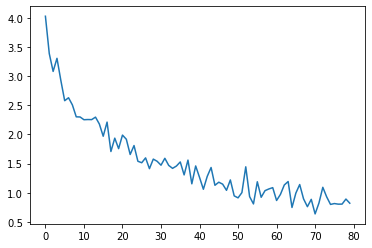

In [58]:
#model.save_weights("exp/ckpt5")
plt.plot(model_fit.history['loss'])
plt.show()

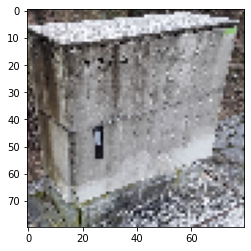

Damaged: 0.0 Good state: 1.0
Body: 1.0 Door: 0.0 None: 0.0 Rusty: 0.0


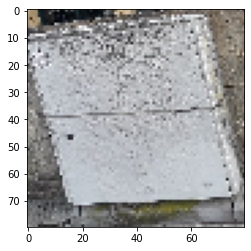

Damaged: 0.0 Good state: 1.0
Body: 1.0 Door: 0.0 None: 0.0 Rusty: 0.0


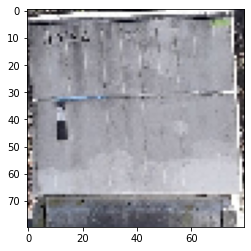

Damaged: 0.0 Good state: 1.0
Body: 1.0 Door: 0.0 None: 0.0 Rusty: 0.0


In [66]:
dir_path = 'learning_data/fine/test/door'
for i in os.listdir(dir_path ):
    img = image.load_img(dir_path+'//'+ i, target_size= (80,80))
    plt.imshow(img)
    plt.show()
    #Convert the images to array
    X = image.img_to_array(img)
    X = np.expand_dims(X,axis= 0)
    images = np.vstack([X])
    label_pred = model.predict(images)
    coarse = label_pred[0]
    fine = label_pred[1]
    print("Damaged:",coarse[0][0], "Good state:",coarse[0][1])
    print("Body:",fine[0][0], "Door:",fine[0][1], "None:",fine[0][2], "Rusty:",fine[0][3])